Reference: [Recommendation System Implementation With Deep Learning and PyTorch](https://medium.com/swlh/recommendation-system-implementation-with-deep-learning-and-pytorch-a03ee84a96f4)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import onnx

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import math
import copy
from pathlib import Path
from itertools import zip_longest

In [3]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

In [4]:
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

# Prepare data

In [6]:
def read_data(path):
    files = {}
    for filename in path.glob('*'):
        if filename.suffix == '.csv':
            files[filename.stem] = pd.read_csv(filename)
    return files['input']
input_df = read_data(Path('data/input'))

In [1295]:
input_df.head()

,Schedule,Time,Distance,Task,Duration,Response
0,11001010101100011101000001001000,16,6.581118,1,0.656583,1
1,00111001000001111001000010101011,23,2.637273,0,0.219067,1
2,01001111001111001001110110011010,23,7.069589,0,0.013320,1
3,10011001111101101101111010010111,7,1.542907,0,0.638135,0
4,01100110011011000001100010100101,11,1.747132,1,0.793390,1


In [7]:
input_df.shape

(10000, 6)

In [8]:
def create_dataset(input_df, top=None):    
    num_entries = input_df.shape[0]
    num_fields = input_df.shape[1] - 1
    
    X = input_df.drop(['Response'], axis=1)
    y = input_df['Response'].astype(int)
    return (num_entries, num_fields), (X, y)

In [9]:
(num_entries, num_fields), (X, y) = create_dataset(input_df)
print(f'{num_entries} entries, {num_fields} fields')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

10000 entries, 5 fields
Dataset shape: (10000, 5)
Target shape: (10000,)


In [10]:
class ReviewsIterator:
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [11]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = [[
                torch.tensor(x_field).float()
                if isinstance(x_field, (int, float)) else x_field for x_field in x
            ] for x in xb]
        xb = [[
                torch.tensor(np.array([int(digit) for digit in x_field])) 
                if isinstance(x_field, str) else x_field for x_field in x
            ] for x in xb]

        xb = [torch.cat([x[0].unsqueeze(0)] + [torch.tensor([[elem]]) for elem in x[1:]], dim=1) for x in xb]
        
        xb = torch.stack(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)

In [12]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[[ 1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
           1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
           1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,
           0.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,  0.0000,
           0.0000,  1.0000,  1.0000,  0.0000, 14.0000,  9.0837,  0.0000,
           0.7738]],

        [[ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,
           1.0000,  0.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.0000,
           1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
           1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,
           0.0000,  0.0000,  1.0000,  0.0000, 22.0000,  1.4950,  0.0000,
           0.6545]],

        [[ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  1.0000,
           0.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.0000,
           1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
       

# Model

In [19]:
class RecommendationModel(nn.Module):
    def __init__(self, num_features, num_factors=50, embedding_dropout=0.02, hidden=10, dropouts=0.2):
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]

        def gen_layers(n_in):
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)

            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out

        self.features = nn.Linear(num_features, num_factors * 2)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(num_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()

    def forward(self, x):
        x = self.features(x)
        x = self.drop(x)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        return out

    def _init(self):
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.features.apply(init)
        self.hidden.apply(init)
        init(self.fc)


def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuration should be a single number or a list of numbers')

In [14]:
RecommendationModel(num_features=num_fields, num_factors=5, hidden=100, dropouts=0.1)

RecommendationModel(
  (features): Linear(in_features=5, out_features=10, bias=True)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

# Training

### Cyclical Learing Rate

In [15]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [16]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler

In [17]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

In [18]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

### Training Loop

In [1308]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

print(dataset_sizes)

{'train': 8000, 'val': 2000}


In [1309]:
rec = RecommendationModel(
    num_features=36, 
    num_factors= 15,
    hidden=[24, 16, 8],
    dropouts=[0.2, 0.1, 0]
)
print(rec)

RecommendationModel(
  (features): Linear(in_features=36, out_features=60, bias=True)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=60, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=200, out_features=300, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=300, out_features=200, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.25, inplace=False)
    (12): Linear(in_features=200, out_features=100, bias=True)
    (13): ReLU()
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


In [1310]:
lr = 1e-3
wd = 1e-5
bs = 2000
n_epochs = 200
patience = 20
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

rec.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(rec.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
if iterations_per_epoch == 0: iterations_per_epoch = 1
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

In [1311]:
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        if phase == 'train':
            training = True
        else:
            training = False

        running_loss = 0
        n_batches = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            x_batch = x_batch.view(x_batch.size(0), -1)
            optimizer.zero_grad()
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = rec(x_batch)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(rec.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

/Users/sharon/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


loss improvement on epoch: 1
[001/200] train: 0.2891 - val: 0.2407
loss improvement on epoch: 2
[002/200] train: 0.2479 - val: 0.2299
loss improvement on epoch: 3
[003/200] train: 0.2268 - val: 0.2150
[004/200] train: 0.2194 - val: 0.2190
[005/200] train: 0.2205 - val: 0.2190
[006/200] train: 0.2197 - val: 0.2155
loss improvement on epoch: 7
[007/200] train: 0.2146 - val: 0.2131
loss improvement on epoch: 8
[008/200] train: 0.2165 - val: 0.2116
[009/200] train: 0.2166 - val: 0.2116
loss improvement on epoch: 10
[010/200] train: 0.2154 - val: 0.2100
[011/200] train: 0.2138 - val: 0.2102
[012/200] train: 0.2144 - val: 0.2105
loss improvement on epoch: 13
[013/200] train: 0.2136 - val: 0.2092
[014/200] train: 0.2142 - val: 0.2094
loss improvement on epoch: 15
[015/200] train: 0.2144 - val: 0.2083
[016/200] train: 0.2138 - val: 0.2099
[017/200] train: 0.2144 - val: 0.2099
[018/200] train: 0.2143 - val: 0.2092
[019/200] train: 0.2137 - val: 0.2087
[020/200] train: 0.2133 - val: 0.2094
[021/

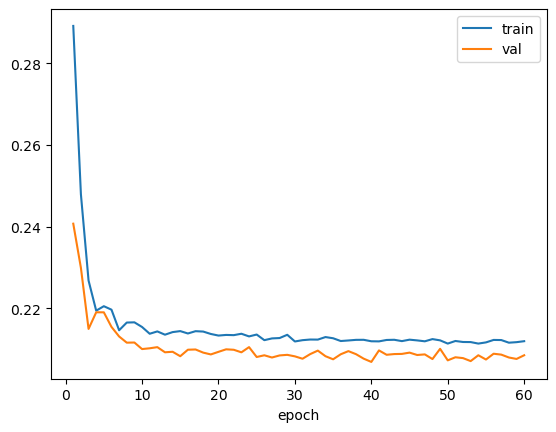

In [1312]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

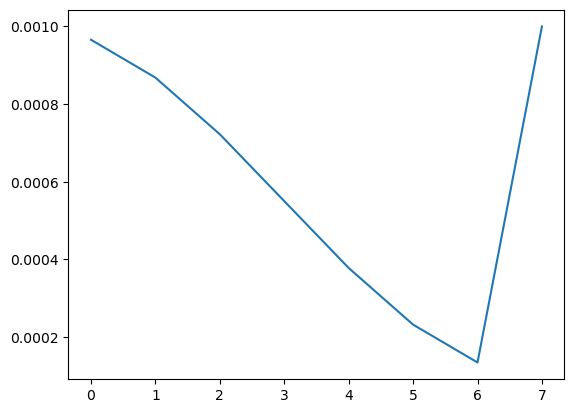

In [1313]:
_ = plt.plot(lr_history[:2*iterations_per_epoch])

In [1314]:
rec.load_state_dict(best_weights)

<All keys matched successfully>

In [1321]:
ground_truth, predictions = [], []
threshold = 0.6

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = rec(x_batch)
        ground_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

ground_truth = np.asarray(ground_truth).ravel()
predictions = np.asarray(predictions).ravel()

print(f'groud_truth: {ground_truth}')
print(f'predictions: {predictions}')

decisions = [0 if pred < threshold else 1 for pred in predictions]
print(f'decisions: {decisions}')
print('rmse: %.4f' % np.sqrt(mean_squared_error(ground_truth, predictions)))

groud_truth: [1. 0. 1. ... 0. 1. 1.]
predictions: [0.63555032 0.59788334 0.61224782 ... 0.59337199 0.5969671  0.62155735]
decisions: [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,

In [1327]:
checkpoint_dir = 'checkpoints'
if os.path.exists(checkpoint_dir) is False:
    os.makedirs(checkpoint_dir)

checkpoint_path = f'{checkpoint_dir}/recmodel.pth'
torch.save(rec, checkpoint_path)

# Save model

In [1328]:
# Save model as ONNX
rec.eval()
dummy_input = torch.randn(1, 36)
torch.onnx.export(rec, dummy_input, 'model.onnx', opset_version=11)

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

